# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [ ] Solve problem with accuracy
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)

## Install TabPFN offline

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [2]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [5]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [6]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [7]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [8]:
def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            out_of_fold.loc[valid_ids, 0] = model.predict(x=valid_ds).flatten()
            submition[i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_ds,return_dict=True)
            train_metric = evaluation["balanced_logloss_tf"]
            
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            val_metric = evaluation["balanced_logloss_tf"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    
            
    return submition,models,metrics

def balanced_logloss_tf(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = tf.reshape(K.log(y_pred_1),[-1,1])
    log_y_pred_0 = tf.reshape(K.log(y_pred_0),[-1,1])

    y_1 = tf.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
    logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpndh5ziw8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:10.551314. Found 555 examples.
Training model...
Model trained in 0:00:00.866324
Compiling model...


[INFO 23-07-20 09:19:50.0112 UTC kernel.cc:1242] Loading model from path /tmp/tmpndh5ziw8/model/ with prefix 3e567aeb76284327
[INFO 23-07-20 09:19:50.1627 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 09:19:50.1629 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:19:50.1632 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 419ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2942


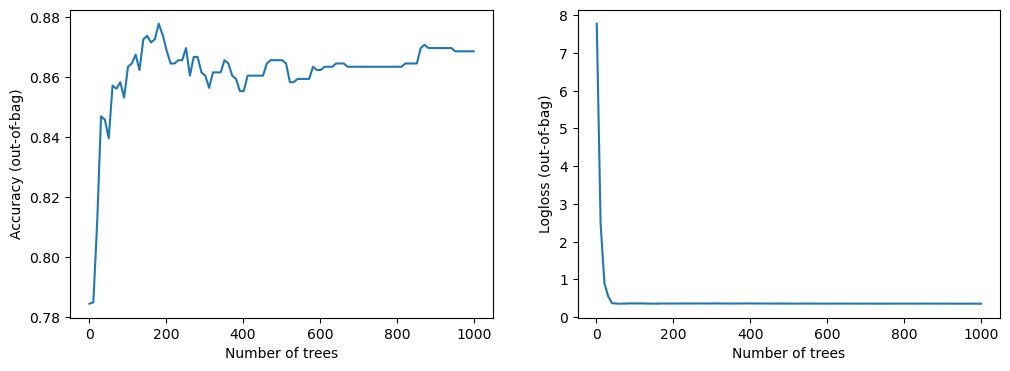


Train: 0.1816 Validation: 0.2942
##### Fold 2
Use /tmp/tmpz1la1aop as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.531930. Found 555 examples.
Training model...
Model trained in 0:00:00.822027
Compiling model...


[INFO 23-07-20 09:20:01.2143 UTC kernel.cc:1242] Loading model from path /tmp/tmpz1la1aop/model/ with prefix e81334a87a9c4c39
[INFO 23-07-20 09:20:01.3676 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34512 node(s), and 113 input feature(s).
[INFO 23-07-20 09:20:01.3680 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:20:01.3683 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 426ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3145


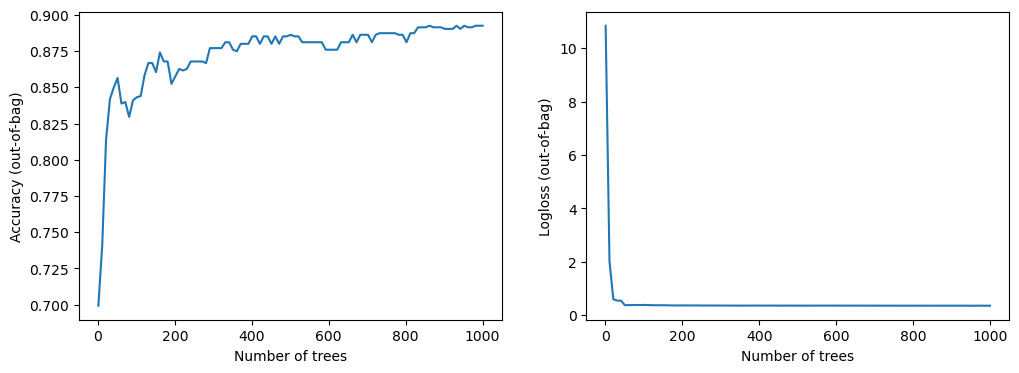


Train: 0.1801 Validation: 0.3145
##### Fold 3
Use /tmp/tmpm_y62xiq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.434106. Found 555 examples.
Training model...
Model trained in 0:00:00.816178
Compiling model...


[INFO 23-07-20 09:20:09.6952 UTC kernel.cc:1242] Loading model from path /tmp/tmpm_y62xiq/model/ with prefix 6e4461660de14808
[INFO 23-07-20 09:20:09.8438 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34332 node(s), and 113 input feature(s).
[INFO 23-07-20 09:20:09.8440 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 407ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4360


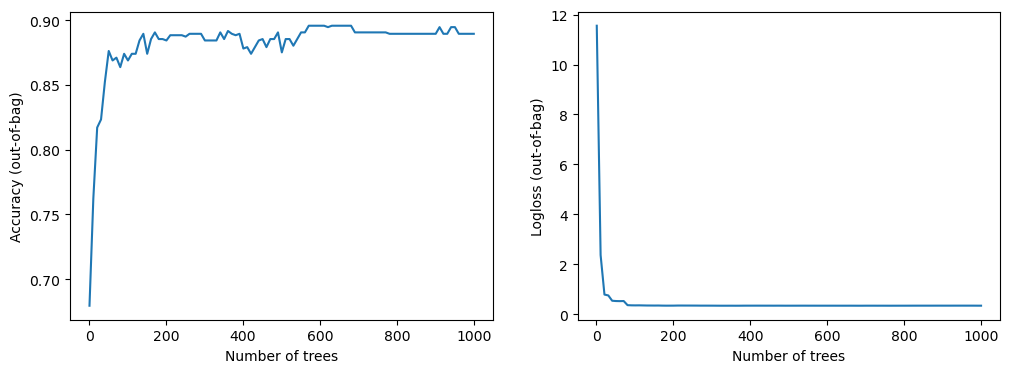


Train: 0.1718 Validation: 0.4360
##### Fold 4
Use /tmp/tmpudtlwwup as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.619655. Found 555 examples.
Training model...
Model trained in 0:00:00.809143
Compiling model...


[INFO 23-07-20 09:20:17.8418 UTC kernel.cc:1242] Loading model from path /tmp/tmpudtlwwup/model/ with prefix 859dab4bf879408e
[INFO 23-07-20 09:20:17.9958 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 09:20:17.9962 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:20:17.9966 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 412ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3325


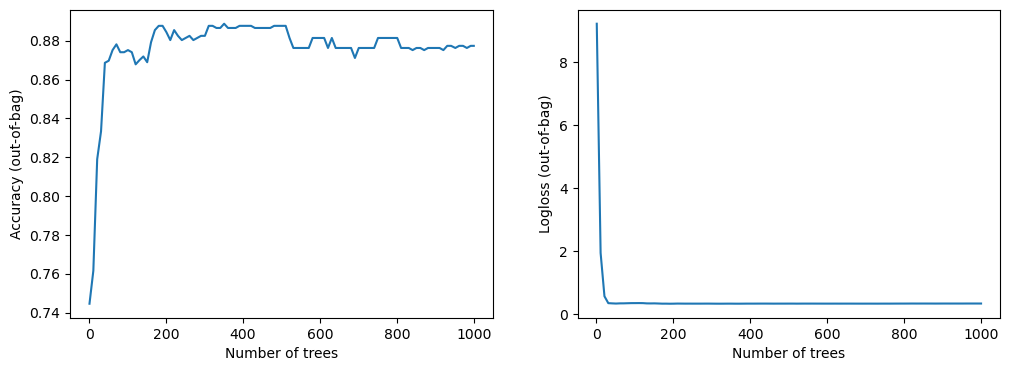


Train: nan Validation: 0.3325
##### Fold 5
Use /tmp/tmptociuk_c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.503987. Found 555 examples.
Training model...
Model trained in 0:00:00.801355
Compiling model...


[INFO 23-07-20 09:20:25.8816 UTC kernel.cc:1242] Loading model from path /tmp/tmptociuk_c/model/ with prefix 00b6f766e00841b6
[INFO 23-07-20 09:20:26.0322 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34614 node(s), and 113 input feature(s).
[INFO 23-07-20 09:20:26.0323 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 418ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3191


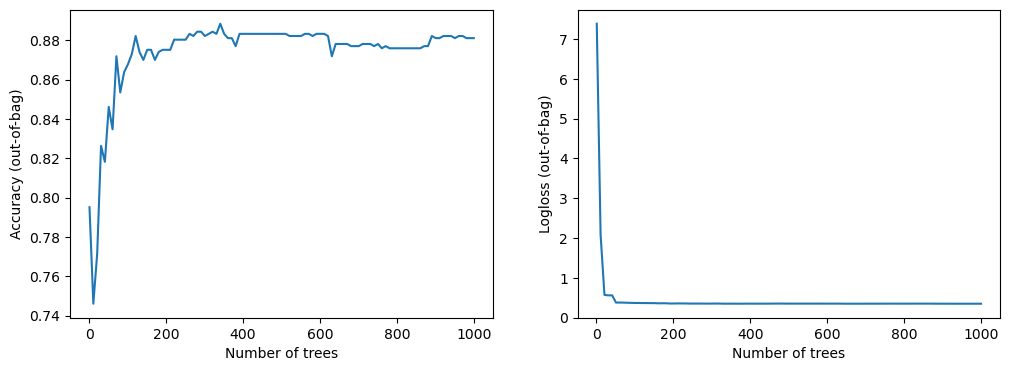


Train: 0.1753 Validation: 0.3191
##### Fold 6
Use /tmp/tmpbf1alnqw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.515503. Found 555 examples.
Training model...
Model trained in 0:00:00.820969
Compiling model...


[INFO 23-07-20 09:20:33.8876 UTC kernel.cc:1242] Loading model from path /tmp/tmpbf1alnqw/model/ with prefix 829b9fa925d14712
[INFO 23-07-20 09:20:34.0395 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34414 node(s), and 113 input feature(s).
[INFO 23-07-20 09:20:34.0397 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:20:34.0399 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 431ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3483


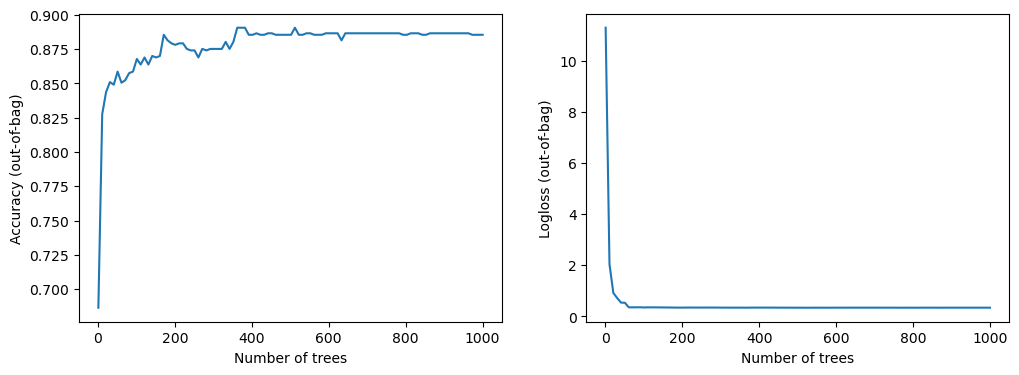


Train: 0.1722 Validation: 0.3483
##### Fold 7
Use /tmp/tmpsxfef59g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.490005. Found 555 examples.
Training model...
Model trained in 0:00:00.813019
Compiling model...


[INFO 23-07-20 09:20:44.8903 UTC kernel.cc:1242] Loading model from path /tmp/tmpsxfef59g/model/ with prefix 00a146c259824a8e
[INFO 23-07-20 09:20:45.0324 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34550 node(s), and 114 input feature(s).
[INFO 23-07-20 09:20:45.0324 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:20:45.0325 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 420ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3973


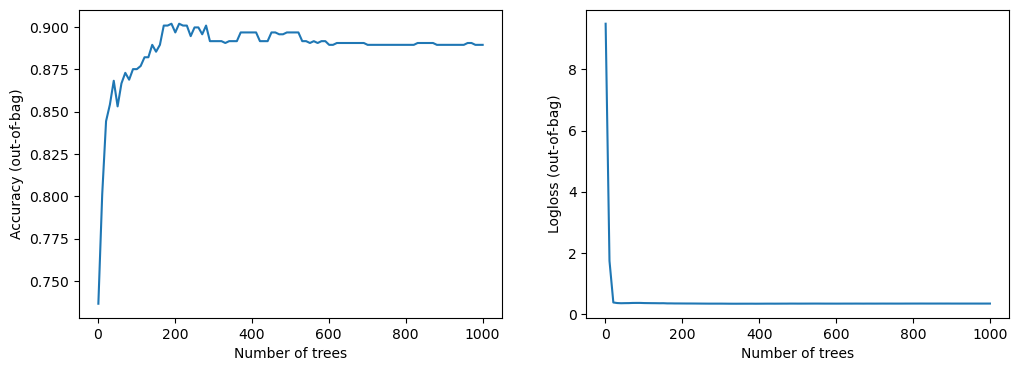


Train: 0.1711 Validation: 0.3973
##### Fold 8
Use /tmp/tmprjh7mjgg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.481747. Found 556 examples.
Training model...
Model trained in 0:00:00.809503
Compiling model...


[INFO 23-07-20 09:20:52.8820 UTC kernel.cc:1242] Loading model from path /tmp/tmprjh7mjgg/model/ with prefix 21ae7974e7144acb
[INFO 23-07-20 09:20:53.0299 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34432 node(s), and 113 input feature(s).
[INFO 23-07-20 09:20:53.0300 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 413ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3383


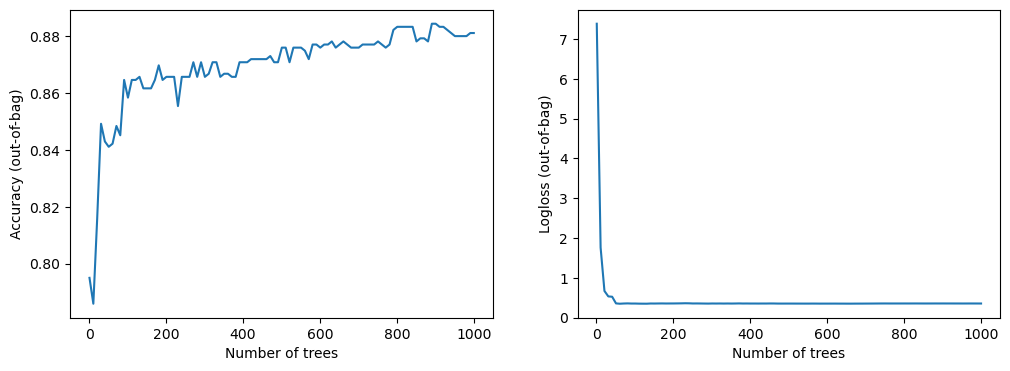


Train: 0.1769 Validation: 0.3383
##### Fold 9
Use /tmp/tmpi3zedz6q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.406961. Found 556 examples.
Training model...
Model trained in 0:00:00.809308
Compiling model...


[INFO 23-07-20 09:21:00.7401 UTC kernel.cc:1242] Loading model from path /tmp/tmpi3zedz6q/model/ with prefix e95d671feb134f06
[INFO 23-07-20 09:21:00.8899 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34142 node(s), and 113 input feature(s).
[INFO 23-07-20 09:21:00.8900 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:21:00.8900 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3867


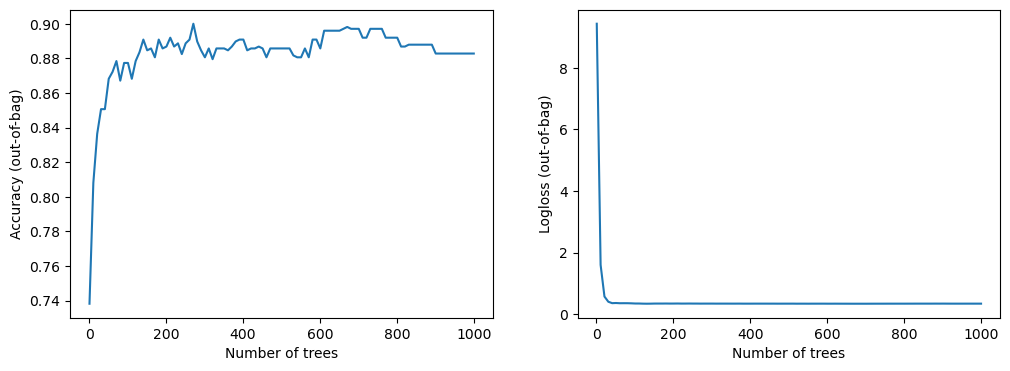


Train: 0.1734 Validation: 0.3867
##### Fold 10
Use /tmp/tmph4d8w6y7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.368825. Found 556 examples.
Training model...
Model trained in 0:00:00.803498
Compiling model...


[INFO 23-07-20 09:21:08.5296 UTC kernel.cc:1242] Loading model from path /tmp/tmph4d8w6y7/model/ with prefix 2964f16dc9504ea4
[INFO 23-07-20 09:21:08.6754 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34820 node(s), and 113 input feature(s).
[INFO 23-07-20 09:21:08.6757 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2814


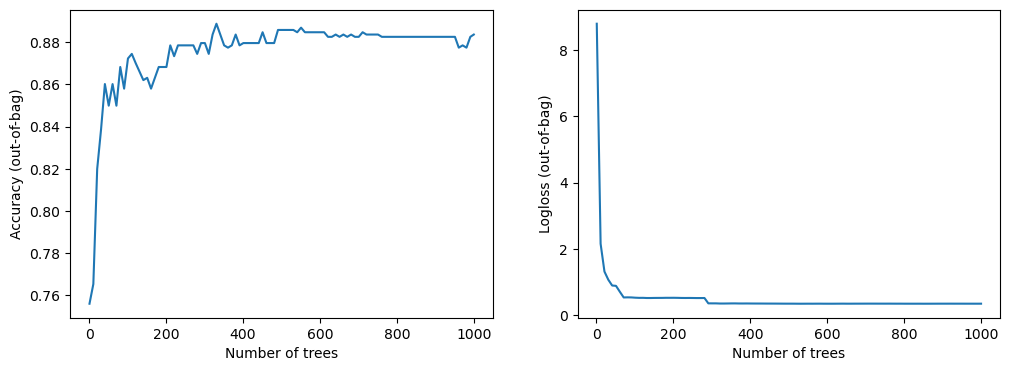


Train: 0.1784 Validation: 0.2814

Train mean: 0.1756 std: 0.0038

Validation mean: 0.3448 std: 0.0485


In [9]:
# RandomForestModel
submition_rf_1, model_rf_1,metrics_rf_1 = train_model(
    train=train_out,test=test_out, features=features,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpr59prqlo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.289048. Found 555 examples.
Training model...
Model trained in 0:00:00.253776
Compiling model...


[INFO 23-07-20 09:21:17.4063 UTC kernel.cc:1242] Loading model from path /tmp/tmpr59prqlo/model/ with prefix c6f0f5fb829e4424
[INFO 23-07-20 09:21:17.4481 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-20 09:21:17.4482 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:21:17.4483 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 414ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3015


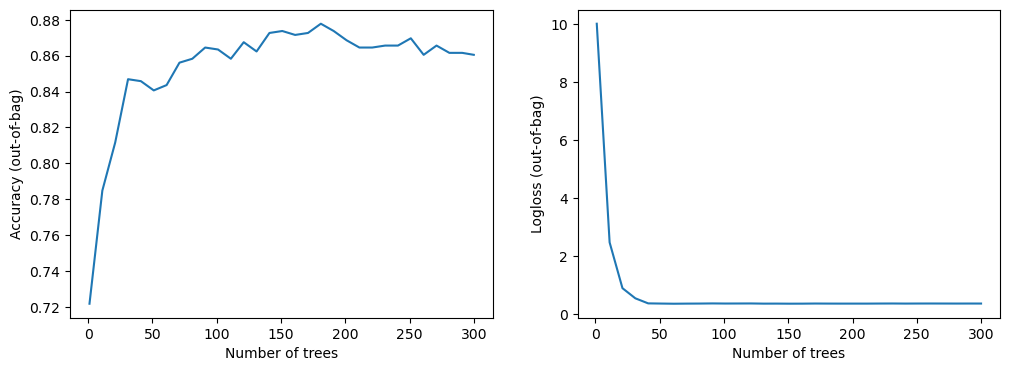


Train: nan Validation: 0.3015
##### Fold 2
Use /tmp/tmpc0ilwzw7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.554280. Found 555 examples.
Training model...
Model trained in 0:00:00.265390
Compiling model...


[INFO 23-07-20 09:21:25.9647 UTC kernel.cc:1242] Loading model from path /tmp/tmpc0ilwzw7/model/ with prefix 4a7f7d06913d4e91
[INFO 23-07-20 09:21:26.0086 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-20 09:21:26.0088 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 401ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3116


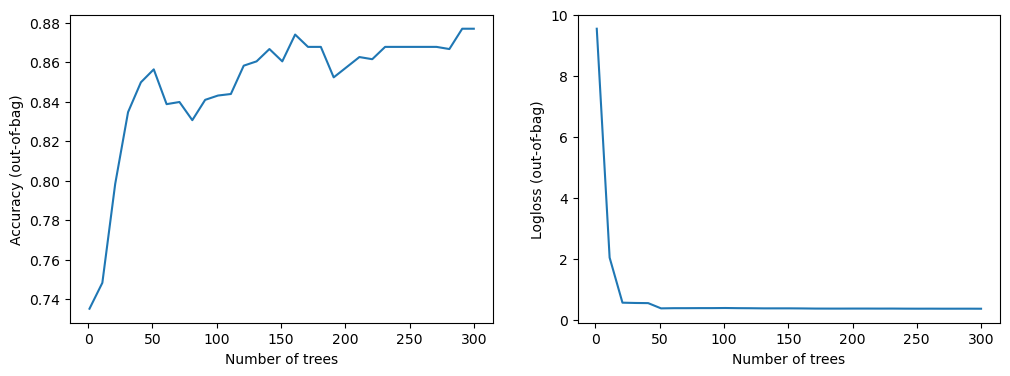


Train: nan Validation: 0.3116
##### Fold 3
Use /tmp/tmpe04n3_79 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.446615. Found 555 examples.
Training model...
Model trained in 0:00:00.261667
Compiling model...


[INFO 23-07-20 09:21:33.3461 UTC kernel.cc:1242] Loading model from path /tmp/tmpe04n3_79/model/ with prefix bccb0b6d4a514d0a
[INFO 23-07-20 09:21:33.3903 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-20 09:21:33.3904 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:21:33.3905 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 436ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4417


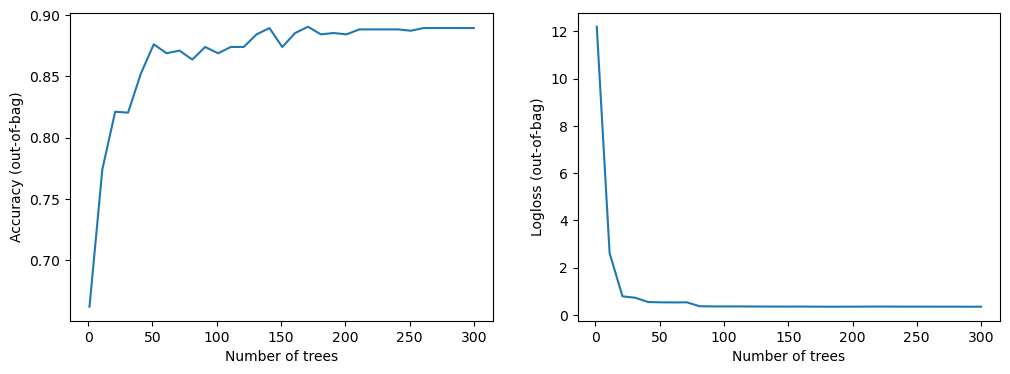


Train: nan Validation: 0.4417
##### Fold 4
Use /tmp/tmpr2g0kesv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.429073. Found 555 examples.
Training model...
Model trained in 0:00:00.254687
Compiling model...


[INFO 23-07-20 09:21:40.7154 UTC kernel.cc:1242] Loading model from path /tmp/tmpr2g0kesv/model/ with prefix a724867875e44520
[INFO 23-07-20 09:21:40.7577 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-20 09:21:40.7579 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 416ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3305


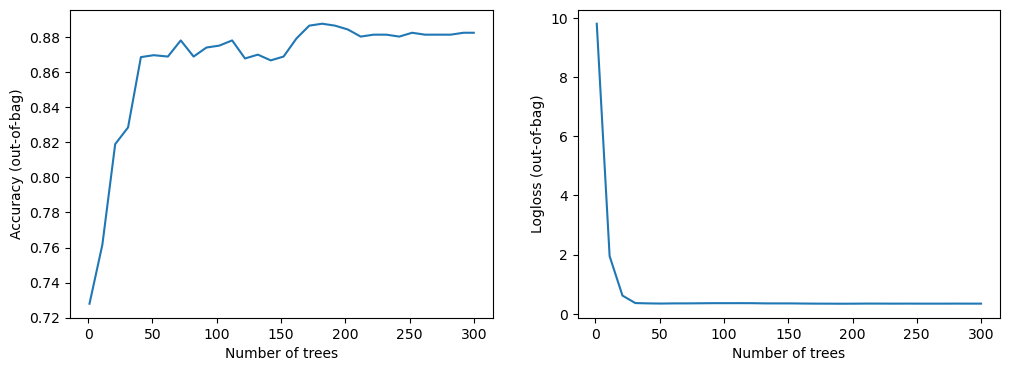


Train: nan Validation: 0.3305
##### Fold 5
Use /tmp/tmpg7w6ccuw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.530181. Found 555 examples.
Training model...
Model trained in 0:00:00.304379
Compiling model...


[INFO 23-07-20 09:21:49.2608 UTC kernel.cc:1242] Loading model from path /tmp/tmpg7w6ccuw/model/ with prefix 0bb21ea88165424a
[INFO 23-07-20 09:21:49.3061 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-20 09:21:49.3061 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:21:49.3062 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3279


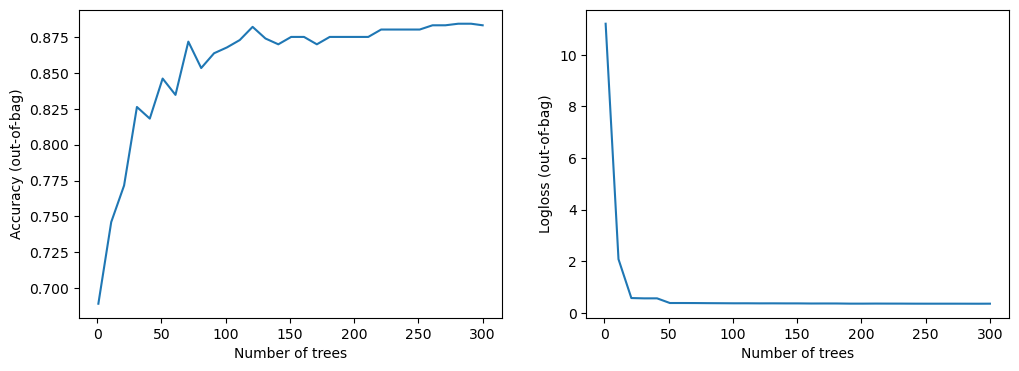


Train: nan Validation: 0.3279
##### Fold 6
Use /tmp/tmpnskhk43_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.465317. Found 555 examples.
Training model...
Model trained in 0:00:00.265743
Compiling model...


[INFO 23-07-20 09:21:56.7382 UTC kernel.cc:1242] Loading model from path /tmp/tmpnskhk43_/model/ with prefix 1952bb9248814ca0
[INFO 23-07-20 09:21:56.7821 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-20 09:21:56.7823 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 439ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


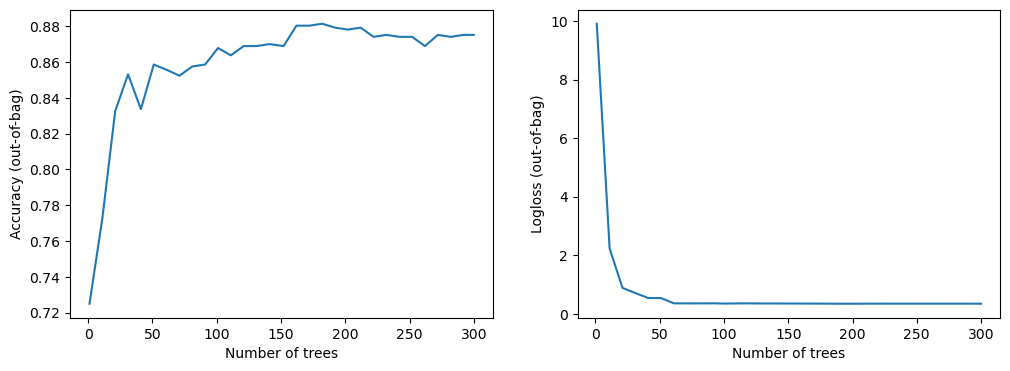


Train: nan Validation: nan
##### Fold 7
Use /tmp/tmp78em7g89 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.529455. Found 555 examples.
Training model...
Model trained in 0:00:00.257919
Compiling model...


[INFO 23-07-20 09:22:05.1882 UTC kernel.cc:1242] Loading model from path /tmp/tmp78em7g89/model/ with prefix 255e1ca242fb4f79
[INFO 23-07-20 09:22:05.2314 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-20 09:22:05.2315 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:22:05.2315 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 415ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4016


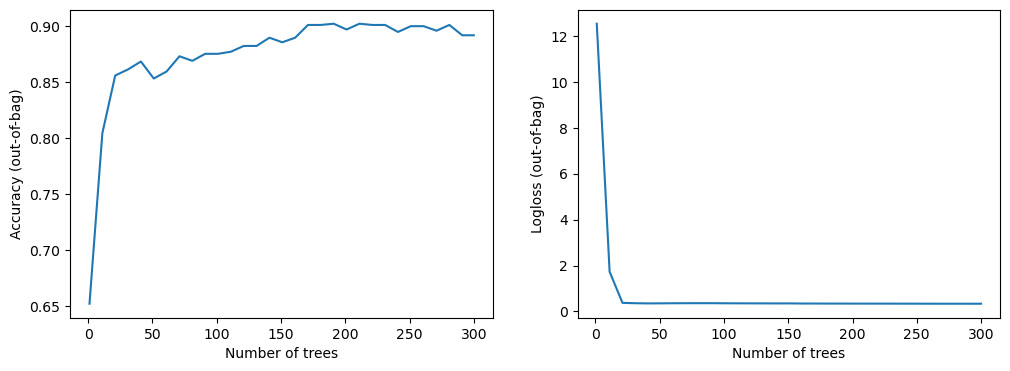


Train: nan Validation: 0.4016
##### Fold 8
Use /tmp/tmpwykou644 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.460250. Found 556 examples.
Training model...
Model trained in 0:00:00.264669
Compiling model...


[INFO 23-07-20 09:22:12.5090 UTC kernel.cc:1242] Loading model from path /tmp/tmpwykou644/model/ with prefix 8bf25da75a414371
[INFO 23-07-20 09:22:12.5544 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-20 09:22:12.5545 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 423ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3344


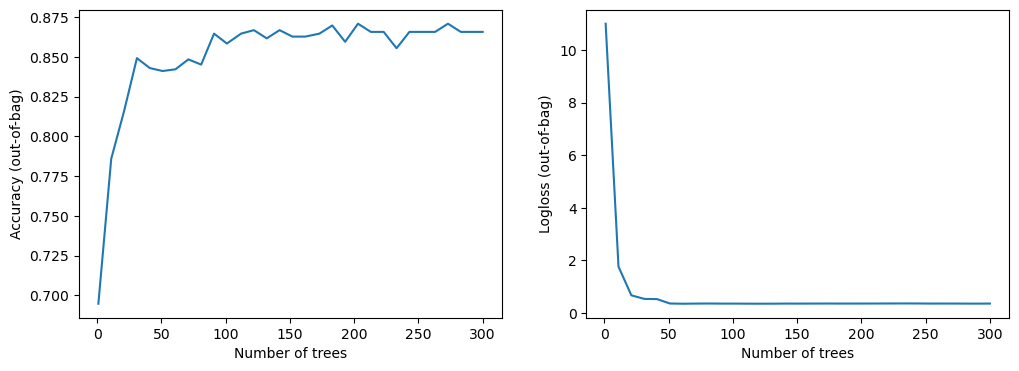


Train: nan Validation: 0.3344
##### Fold 9
Use /tmp/tmpxqhkb60c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.471151. Found 556 examples.
Training model...
Model trained in 0:00:00.265727
Compiling model...


[INFO 23-07-20 09:22:20.0233 UTC kernel.cc:1242] Loading model from path /tmp/tmpxqhkb60c/model/ with prefix d7e964a5941b4389
[INFO 23-07-20 09:22:20.0666 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-20 09:22:20.0667 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:22:20.0667 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 404ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4160


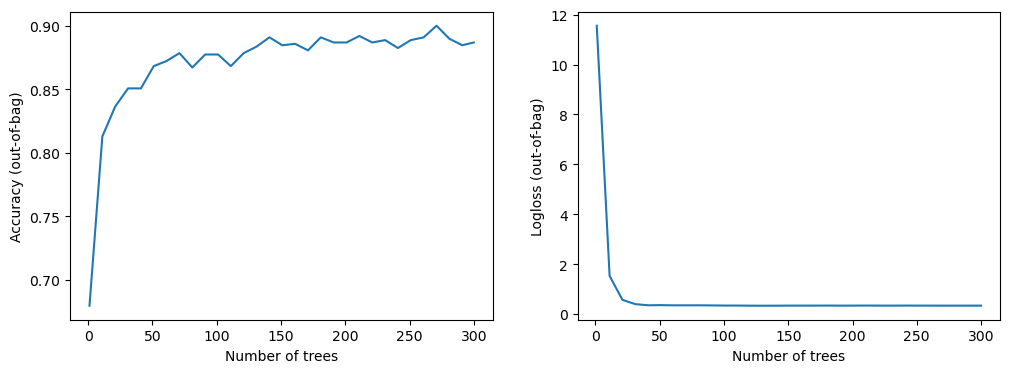


Train: nan Validation: 0.4160
##### Fold 10
Use /tmp/tmpoq0ln1s6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.558487. Found 556 examples.
Training model...
Model trained in 0:00:00.262837
Compiling model...


[INFO 23-07-20 09:22:28.4614 UTC kernel.cc:1242] Loading model from path /tmp/tmpoq0ln1s6/model/ with prefix 0682d251ad3e4c2b
[INFO 23-07-20 09:22:28.5044 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-20 09:22:28.5045 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 418ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2804


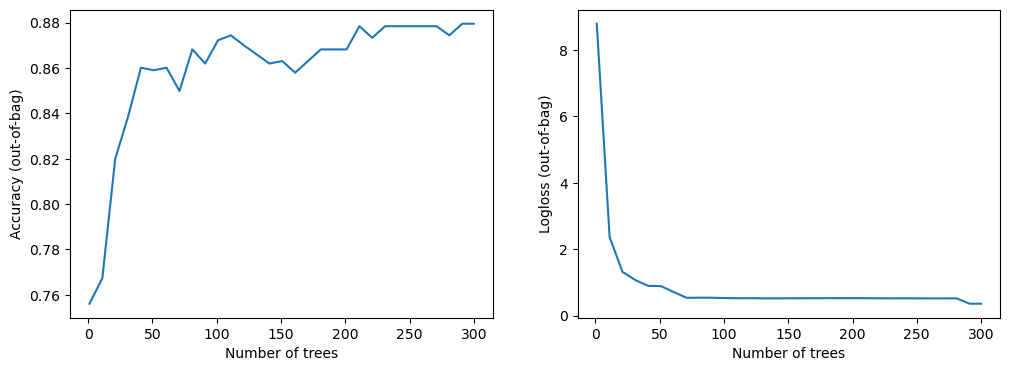


Train: nan Validation: 0.2804

Train mean: nan std: nan

Validation mean: 0.3495 std: 0.0561


In [10]:
# RandomForestModel
submition_rf_2, model_rf_2,metrics_rf_2 = train_model(
    train=train_out,test=test_out, features=features,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp2w05j32r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.459884. Found 555 examples.
Training model...
Model trained in 0:00:00.203548
Compiling model...


[INFO 23-07-20 09:22:35.9316 UTC kernel.cc:1242] Loading model from path /tmp/tmp2w05j32r/model/ with prefix 1e734efa288c406f
[INFO 23-07-20 09:22:35.9775 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-20 09:22:35.9775 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:22:35.9776 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 306ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2470


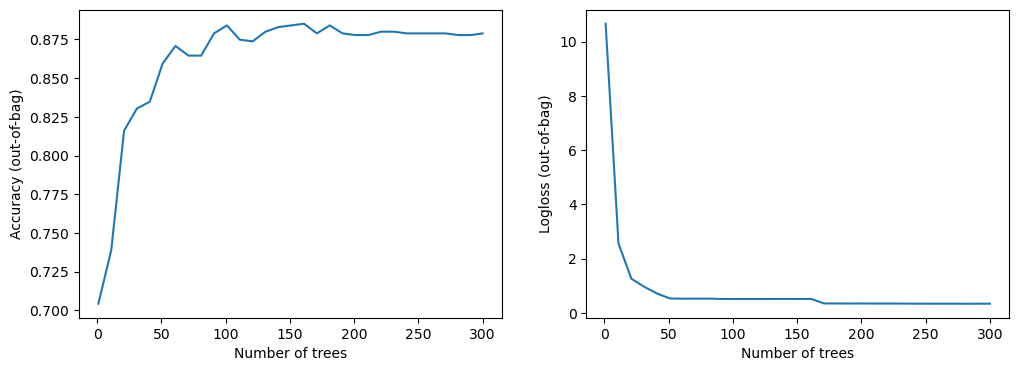


Train: nan Validation: 0.2470
##### Fold 2
Use /tmp/tmp5w_n_cx8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.440063. Found 555 examples.
Training model...
Model trained in 0:00:00.204011
Compiling model...


[INFO 23-07-20 09:22:40.9194 UTC kernel.cc:1242] Loading model from path /tmp/tmp5w_n_cx8/model/ with prefix db42c9d4b01144bb
[INFO 23-07-20 09:22:40.9668 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 09:22:40.9668 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 297ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2757


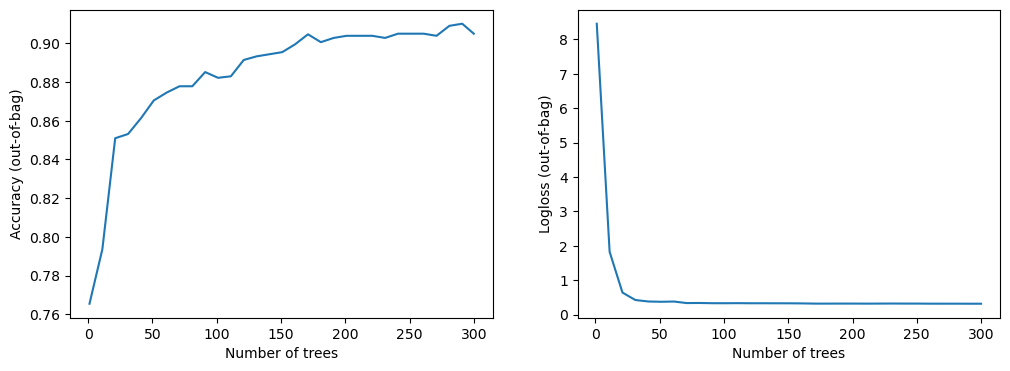


Train: nan Validation: 0.2757
##### Fold 3
Use /tmp/tmpg69c6dhs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.426922. Found 555 examples.
Training model...
Model trained in 0:00:00.196494
Compiling model...


[INFO 23-07-20 09:22:45.8359 UTC kernel.cc:1242] Loading model from path /tmp/tmpg69c6dhs/model/ with prefix f96f722a42464d9f
[INFO 23-07-20 09:22:45.8800 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-20 09:22:45.8800 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 298ms/step - loss: 0.0000e+00 - accuracy: 0.0323 - balanced_logloss_tf: nan


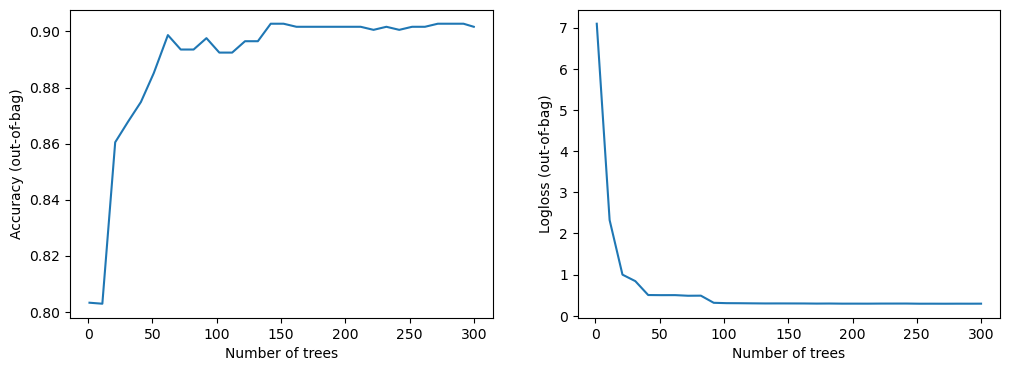


Train: nan Validation: nan
##### Fold 4
Use /tmp/tmp2rigpr2n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.494307. Found 555 examples.
Training model...
Model trained in 0:00:00.269638
Compiling model...


[INFO 23-07-20 09:22:51.8631 UTC kernel.cc:1242] Loading model from path /tmp/tmp2rigpr2n/model/ with prefix 7701706341e54f79
[INFO 23-07-20 09:22:51.9167 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 09:22:51.9168 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:22:51.9168 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 303ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


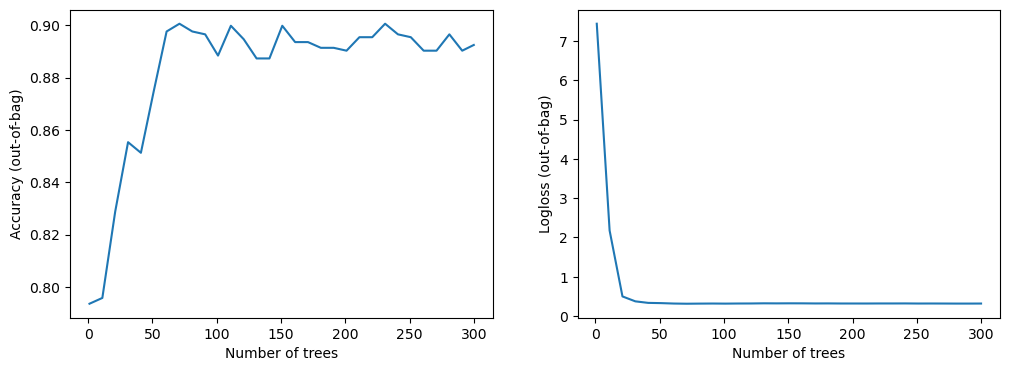


Train: nan Validation: nan
##### Fold 5
Use /tmp/tmpsnix6bhw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.575824. Found 555 examples.
Training model...
Model trained in 0:00:00.211069
Compiling model...


[INFO 23-07-20 09:22:56.9811 UTC kernel.cc:1242] Loading model from path /tmp/tmpsnix6bhw/model/ with prefix bd04309d47014c9f
[INFO 23-07-20 09:22:57.0289 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-20 09:22:57.0290 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 305ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


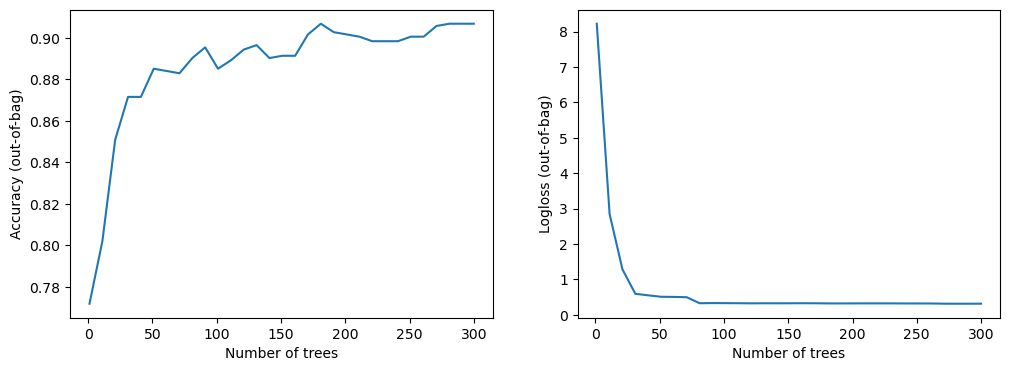


Train: nan Validation: nan
##### Fold 6
Use /tmp/tmpp49bz9wy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.484861. Found 555 examples.
Training model...
Model trained in 0:00:00.201978
Compiling model...


[INFO 23-07-20 09:23:01.9907 UTC kernel.cc:1242] Loading model from path /tmp/tmpp49bz9wy/model/ with prefix ffc7c9f70e754bc2
[INFO 23-07-20 09:23:02.0367 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-20 09:23:02.0368 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:23:02.0368 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 319ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


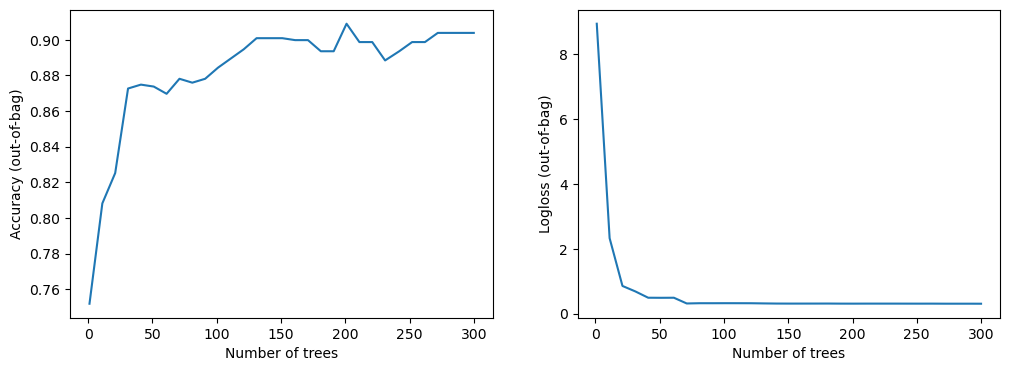


Train: nan Validation: nan
##### Fold 7
Use /tmp/tmp3xn1vgv9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.455995. Found 555 examples.
Training model...
Model trained in 0:00:00.200822
Compiling model...


[INFO 23-07-20 09:23:07.2195 UTC kernel.cc:1242] Loading model from path /tmp/tmp3xn1vgv9/model/ with prefix 318dc5e430b541f5
[INFO 23-07-20 09:23:07.2650 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-20 09:23:07.2650 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 314ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


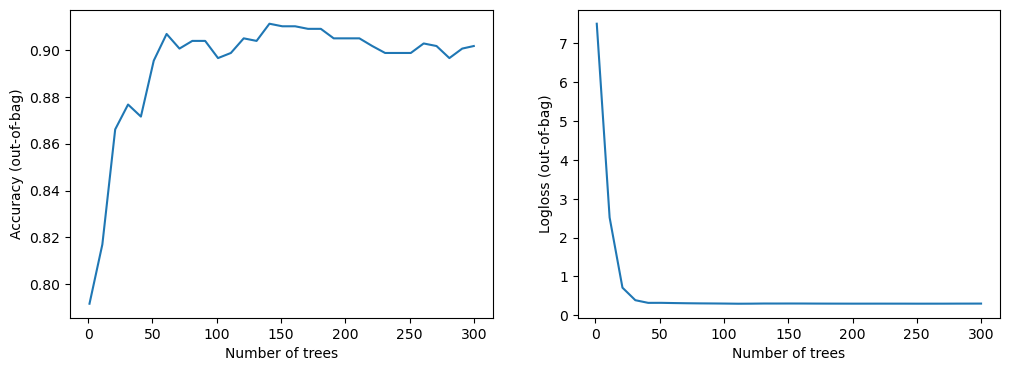


Train: nan Validation: nan
##### Fold 8
Use /tmp/tmpsom74hgm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.415268. Found 556 examples.
Training model...
Model trained in 0:00:00.209470
Compiling model...


[INFO 23-07-20 09:23:12.0733 UTC kernel.cc:1242] Loading model from path /tmp/tmpsom74hgm/model/ with prefix a286703fa25b4bcd
[INFO 23-07-20 09:23:12.1198 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-20 09:23:12.1199 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:23:12.1199 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 295ms/step - loss: 0.0000e+00 - accuracy: 0.0328 - balanced_logloss_tf: nan


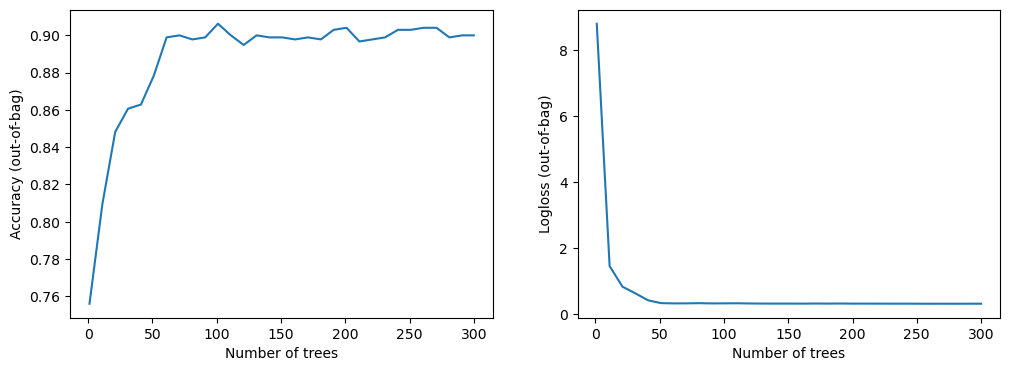


Train: nan Validation: nan
##### Fold 9
Use /tmp/tmpyabheu0i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.468786. Found 556 examples.
Training model...
Model trained in 0:00:00.206849
Compiling model...


[INFO 23-07-20 09:23:17.2250 UTC kernel.cc:1242] Loading model from path /tmp/tmpyabheu0i/model/ with prefix 56fe90ed21ca4763
[INFO 23-07-20 09:23:17.2711 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-20 09:23:17.2712 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 307ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3449


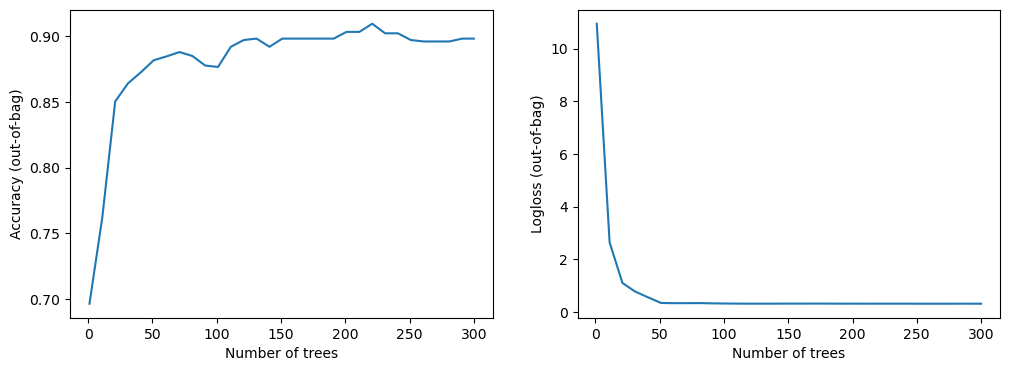


Train: nan Validation: 0.3449
##### Fold 10
Use /tmp/tmpv393rgqk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.479243. Found 556 examples.
Training model...
Model trained in 0:00:00.210062
Compiling model...


[INFO 23-07-20 09:23:22.3414 UTC kernel.cc:1242] Loading model from path /tmp/tmpv393rgqk/model/ with prefix 78939be98f4f4831
[INFO 23-07-20 09:23:22.3884 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-20 09:23:22.3885 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 09:23:22.3885 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 302ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2687


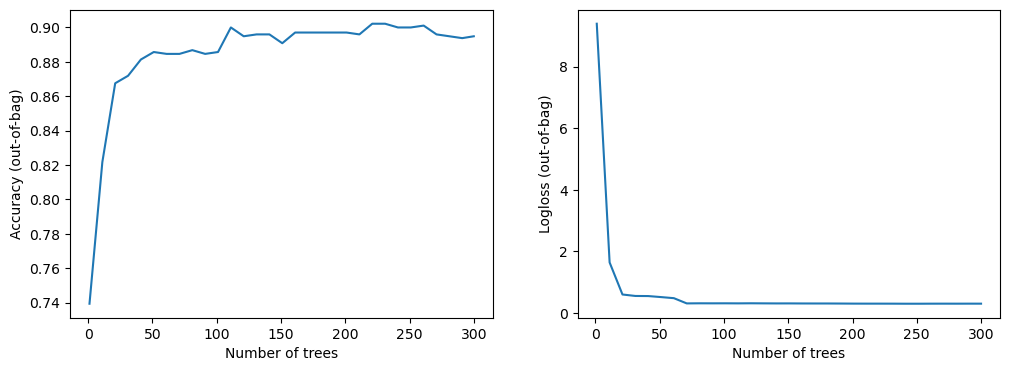


Train: nan Validation: 0.2687

Train mean: nan std: nan

Validation mean: 0.2840 std: 0.0423


In [11]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

submition_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpx4mu3poc as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:23:26.1524 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:26.1525 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:26.1525 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.483951. Found 555 examples.
Training model...
Model trained in 0:00:02.257946
Compiling model...


[INFO 23-07-20 09:23:29.8831 UTC kernel.cc:1242] Loading model from path /tmp/tmpx4mu3poc/model/ with prefix 9adb62793f39479a
[INFO 23-07-20 09:23:29.9056 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 299ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.0299


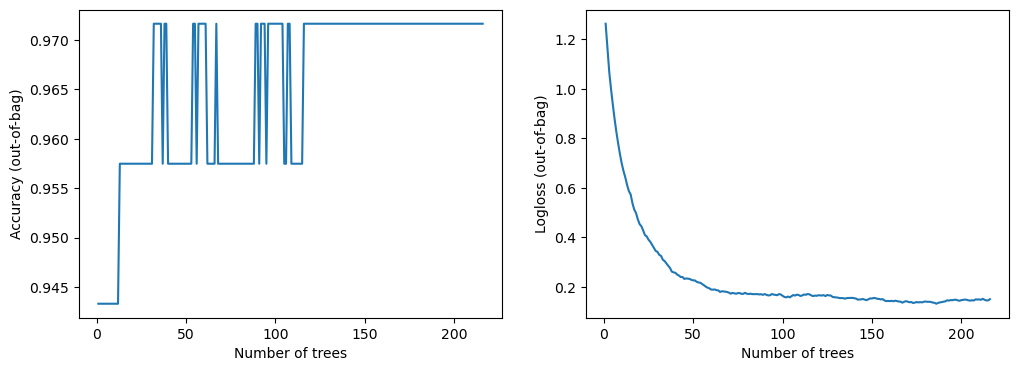


Train: 0.0060 Validation: 0.0299
##### Fold 2
Use /tmp/tmp1g_l40gb as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:23:35.2433 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:35.2434 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:35.2434 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.442532. Found 555 examples.
Training model...
Model trained in 0:00:01.927568
Compiling model...


[INFO 23-07-20 09:23:38.6067 UTC kernel.cc:1242] Loading model from path /tmp/tmp1g_l40gb/model/ with prefix 62090ff6550f49a2
[INFO 23-07-20 09:23:38.6254 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:23:38.6255 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 285ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1438


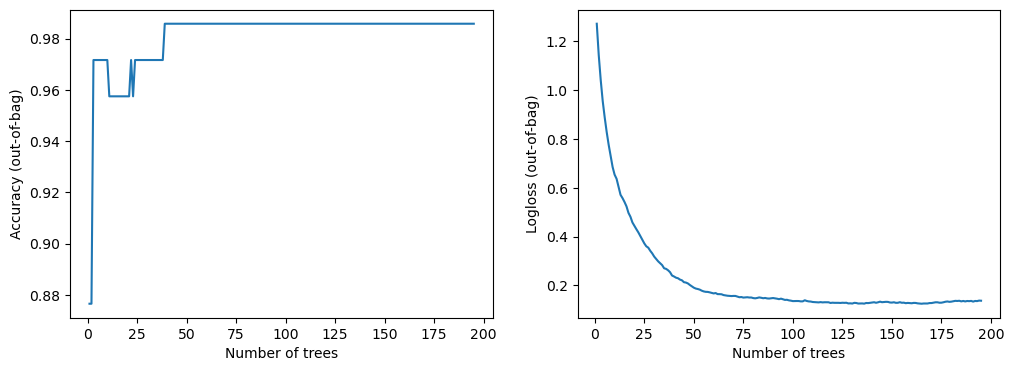


Train: 0.0060 Validation: 0.1438
##### Fold 3
Use /tmp/tmpwph_ugfw as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:23:41.6938 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:41.6938 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:41.6939 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.415544. Found 555 examples.
Training model...
Model trained in 0:00:02.559216
Compiling model...


[INFO 23-07-20 09:23:45.6549 UTC kernel.cc:1242] Loading model from path /tmp/tmpwph_ugfw/model/ with prefix 6247d1cb5a494215
[INFO 23-07-20 09:23:45.6797 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 295ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.8838


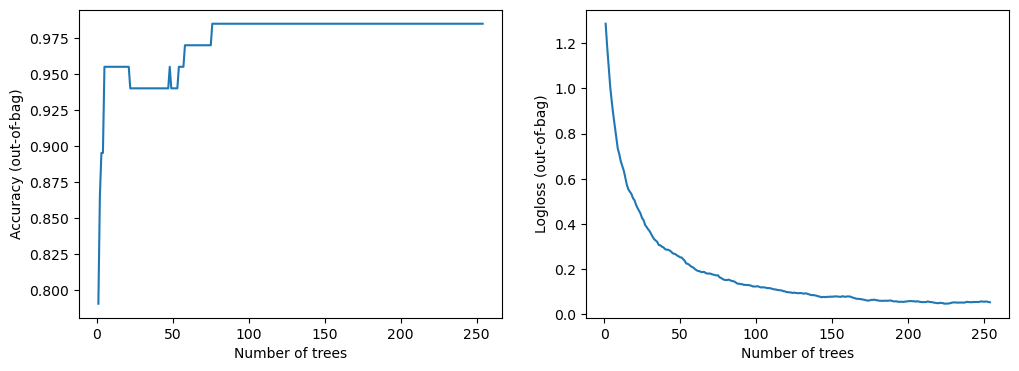


Train: 0.0019 Validation: 0.8838
##### Fold 4
Use /tmp/tmp6obdgpic as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:23:50.5808 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:50.5808 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:50.5809 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.344742. Found 555 examples.
Training model...
Model trained in 0:00:02.734313
Compiling model...


[INFO 23-07-20 09:23:54.6427 UTC kernel.cc:1242] Loading model from path /tmp/tmp6obdgpic/model/ with prefix bc85f31fe0664dc7
[INFO 23-07-20 09:23:54.6698 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:23:54.6699 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 295ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3553


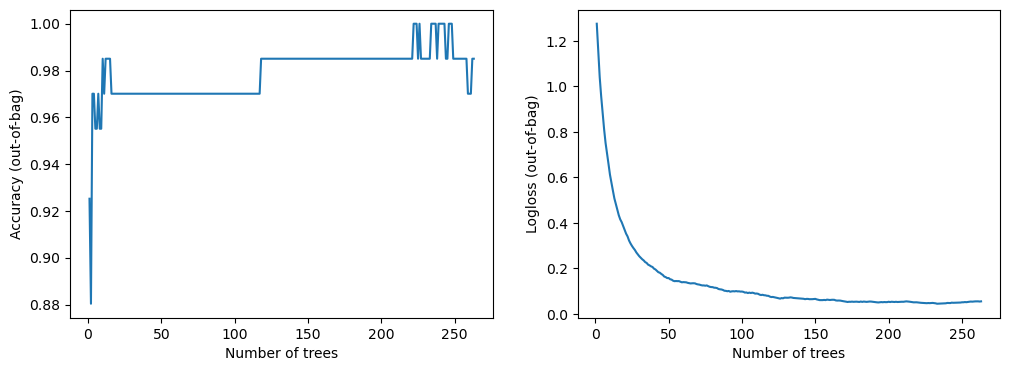


Train: 0.0018 Validation: 0.3553
##### Fold 5
Use /tmp/tmpm8cu0zak as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:23:59.3565 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:59.3565 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:23:59.3566 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.485911. Found 555 examples.
Training model...
Model trained in 0:00:02.745065
Compiling model...


[INFO 23-07-20 09:24:03.5693 UTC kernel.cc:1242] Loading model from path /tmp/tmpm8cu0zak/model/ with prefix b4b772eabda54ec2
[INFO 23-07-20 09:24:03.5968 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 290ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.5371


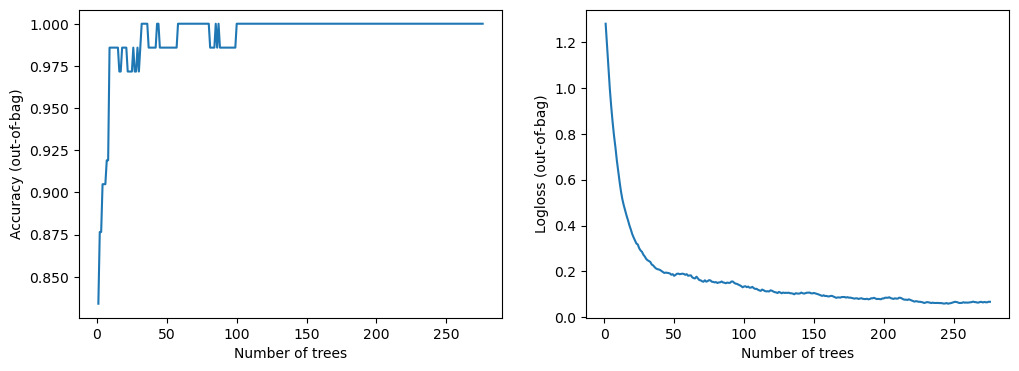


Train: 0.0024 Validation: 0.5371
##### Fold 6
Use /tmp/tmpqwh26bpi as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:06.6665 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:06.6667 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:06.6669 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.364277. Found 555 examples.
Training model...
Model trained in 0:00:01.406447
Compiling model...


[INFO 23-07-20 09:24:09.4362 UTC kernel.cc:1242] Loading model from path /tmp/tmpqwh26bpi/model/ with prefix d34157aff92644f9
[INFO 23-07-20 09:24:09.4494 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:24:09.4496 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 287ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2998


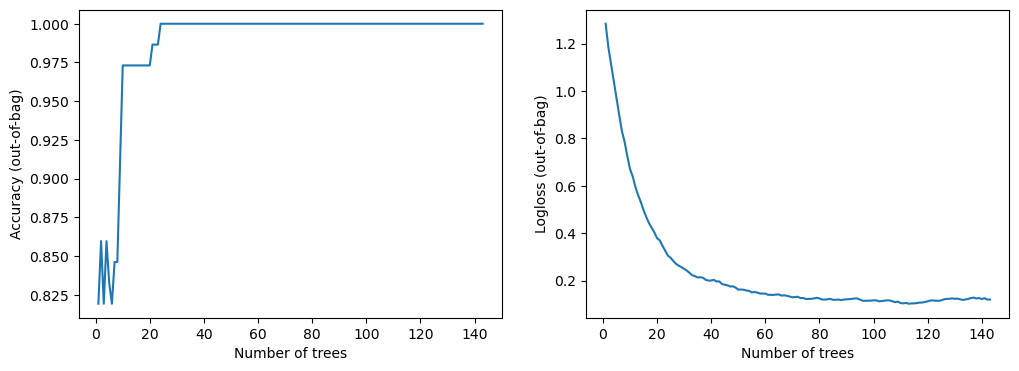


Train: 0.0096 Validation: 0.2998
##### Fold 7
Use /tmp/tmpwpk_4rlw as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:12.5809 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:12.5809 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:12.5810 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.430241. Found 555 examples.
Training model...
Model trained in 0:00:00.667851
Compiling model...


[INFO 23-07-20 09:24:14.6844 UTC kernel.cc:1242] Loading model from path /tmp/tmpwpk_4rlw/model/ with prefix edf86c33cbea4ef0
[INFO 23-07-20 09:24:14.6894 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 293ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3052


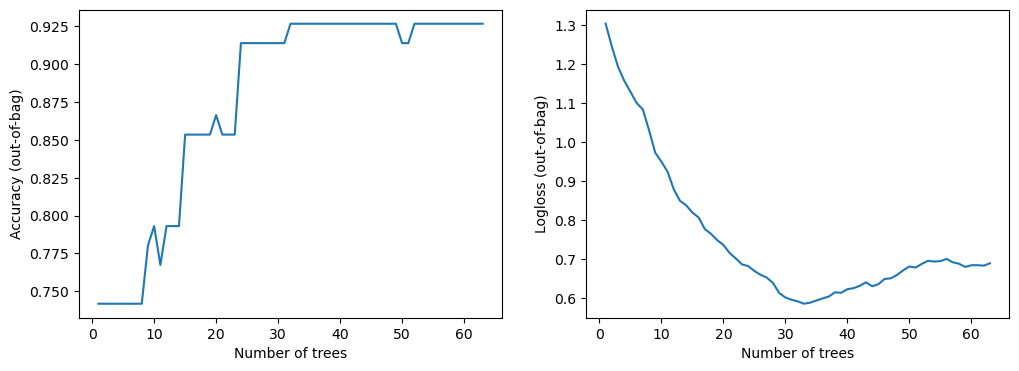


Train: 0.1055 Validation: 0.3052
##### Fold 8
Use /tmp/tmpeh_20d8j as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:18.9629 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:18.9629 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:18.9629 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.381490. Found 556 examples.
Training model...
Model trained in 0:00:00.646874
Compiling model...


[INFO 23-07-20 09:24:20.9982 UTC kernel.cc:1242] Loading model from path /tmp/tmpeh_20d8j/model/ with prefix 2f8f722ba13f4e95
[INFO 23-07-20 09:24:21.0031 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:24:21.0032 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 298ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3190


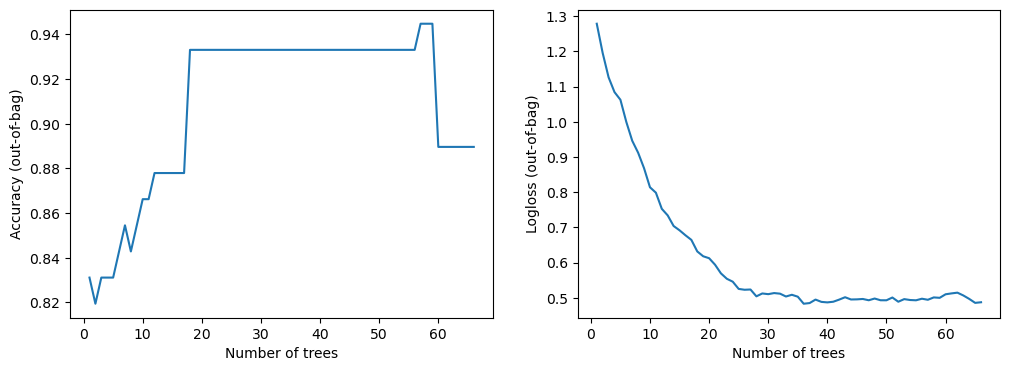


Train: 0.0954 Validation: 0.3190
##### Fold 9
Use /tmp/tmpxdeqqdsd as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:25.4734 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:25.4734 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:25.4734 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.436641. Found 556 examples.
Training model...
Model trained in 0:00:01.022960
Compiling model...


[INFO 23-07-20 09:24:27.9339 UTC kernel.cc:1242] Loading model from path /tmp/tmpxdeqqdsd/model/ with prefix 874d6b882fbf4f20
[INFO 23-07-20 09:24:27.9433 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4456


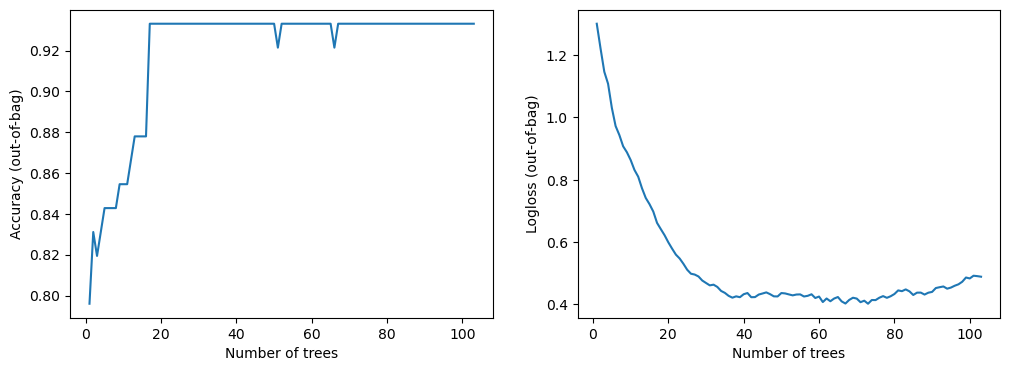


Train: 0.0349 Validation: 0.4456
##### Fold 10
Use /tmp/tmpjdfg113b as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:31.1030 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:31.1030 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:31.1031 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.419971. Found 556 examples.
Training model...
Model trained in 0:00:00.667950
Compiling model...


[INFO 23-07-20 09:24:33.1999 UTC kernel.cc:1242] Loading model from path /tmp/tmpjdfg113b/model/ with prefix 2907ecf2aa5c40c1
[INFO 23-07-20 09:24:33.2049 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:24:33.2049 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 292ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2912


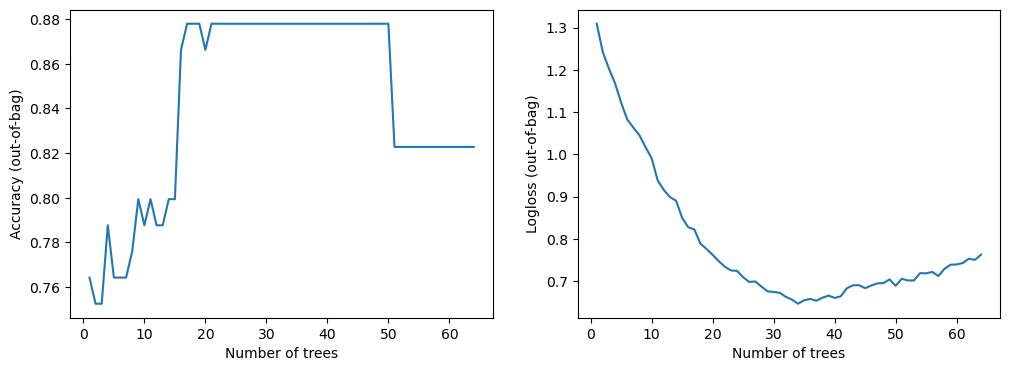


Train: 0.1098 Validation: 0.2912

Train mean: 0.0373 std: 0.0469

Validation mean: 0.3611 std: 0.2314


In [12]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpyhqiyxco as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:36.7074 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:36.7074 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:36.7074 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.552906. Found 555 examples.
Training model...
Model trained in 0:00:01.102546
Compiling model...


[INFO 23-07-20 09:24:39.3656 UTC kernel.cc:1242] Loading model from path /tmp/tmpyhqiyxco/model/ with prefix b4c08cd732bf421a
[INFO 23-07-20 09:24:39.3771 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 299ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1640


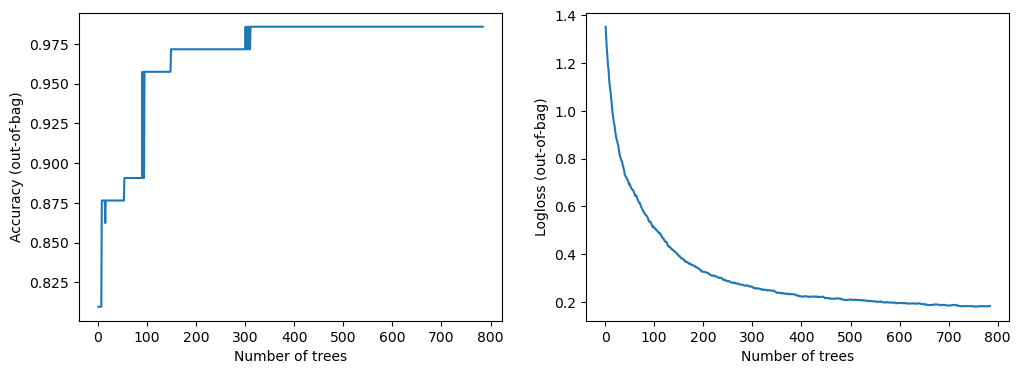


Train: 0.1127 Validation: 0.1640
##### Fold 2
Use /tmp/tmpd7n2a61b as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:42.6707 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:42.6708 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:42.6708 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.451788. Found 555 examples.
Training model...
Model trained in 0:00:00.719393
Compiling model...


[INFO 23-07-20 09:24:44.8476 UTC kernel.cc:1242] Loading model from path /tmp/tmpd7n2a61b/model/ with prefix 00666f29c8c14ad0
[INFO 23-07-20 09:24:44.8550 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:24:44.8550 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1576


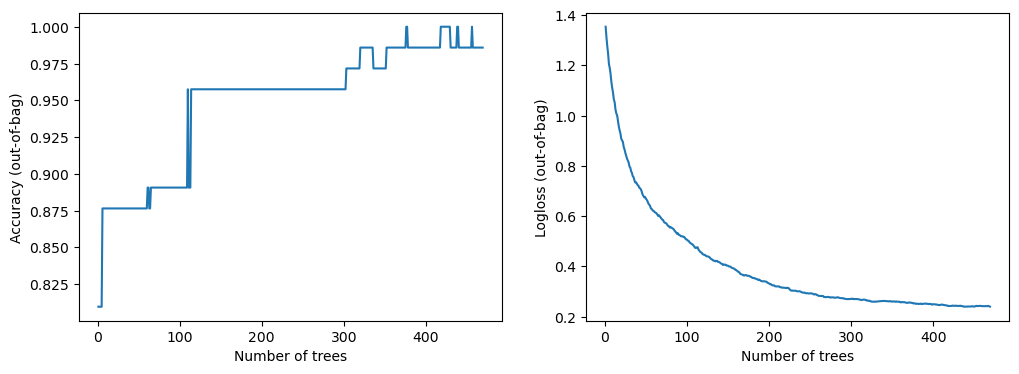


Train: 0.1418 Validation: 0.1576
##### Fold 3
Use /tmp/tmpibshe_ul as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:48.0348 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:48.0348 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:48.0349 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.401125. Found 555 examples.
Training model...
Model trained in 0:00:00.785701
Compiling model...


[INFO 23-07-20 09:24:50.2244 UTC kernel.cc:1242] Loading model from path /tmp/tmpibshe_ul/model/ with prefix 5c80d93d8db64472
[INFO 23-07-20 09:24:50.2325 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 285ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3384


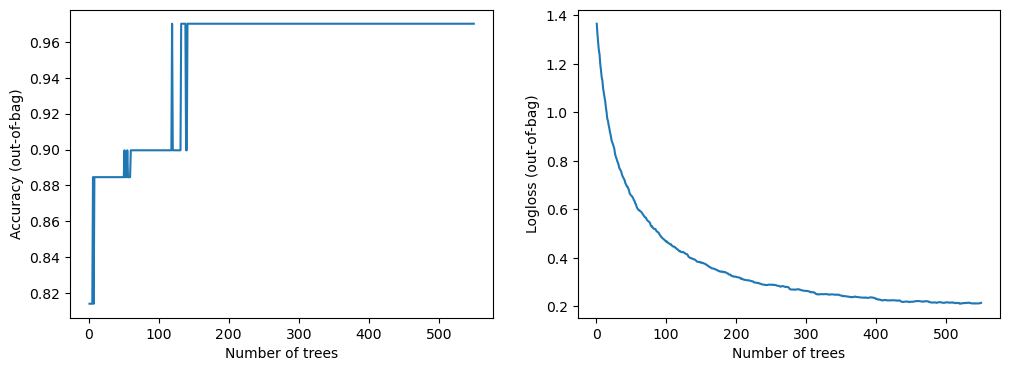


Train: 0.1189 Validation: 0.3384
##### Fold 4
Use /tmp/tmp7tx0arre as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:24:54.4406 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:54.4406 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:24:54.4406 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.378776. Found 555 examples.
Training model...
Model trained in 0:00:00.773407
Compiling model...


[INFO 23-07-20 09:24:56.5953 UTC kernel.cc:1242] Loading model from path /tmp/tmp7tx0arre/model/ with prefix 65a54c7da96747ab
[INFO 23-07-20 09:24:56.6025 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:24:56.6026 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 305ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2671


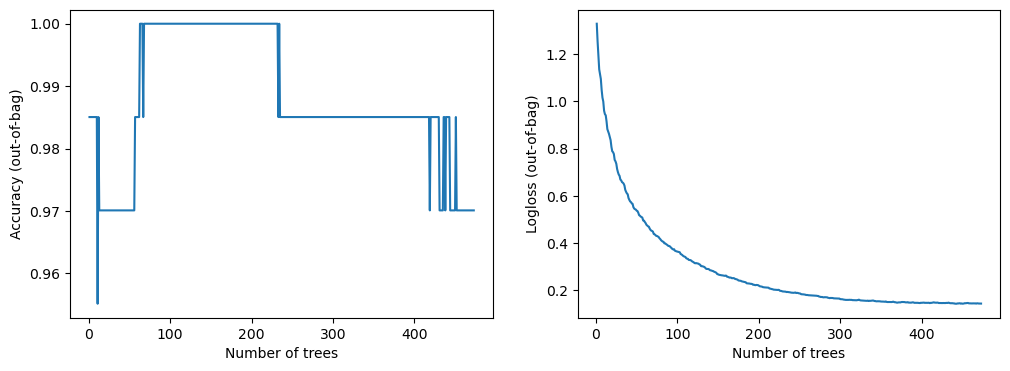


Train: 0.1329 Validation: 0.2671
##### Fold 5
Use /tmp/tmpl1efvwof as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:25:02.0471 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:02.0472 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:02.0472 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.399383. Found 555 examples.
Training model...
Model trained in 0:00:01.069640
Compiling model...


[INFO 23-07-20 09:25:04.5189 UTC kernel.cc:1242] Loading model from path /tmp/tmpl1efvwof/model/ with prefix ae76f7b9048342a9
[INFO 23-07-20 09:25:04.5292 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 293ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2613


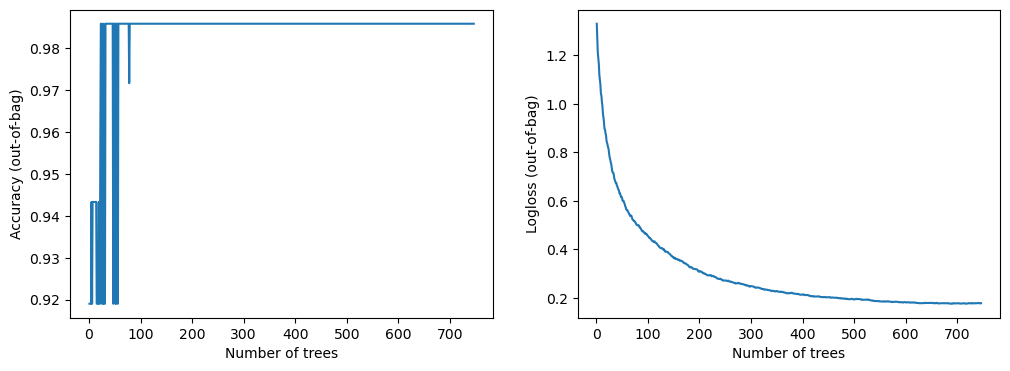


Train: 0.1059 Validation: 0.2613
##### Fold 6
Use /tmp/tmp60y2i7bs as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:25:08.4189 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:08.4189 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:08.4190 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.390077. Found 555 examples.
Training model...
Model trained in 0:00:01.216886
Compiling model...


[INFO 23-07-20 09:25:11.0255 UTC kernel.cc:1242] Loading model from path /tmp/tmp60y2i7bs/model/ with prefix d77e8034d6de450c
[INFO 23-07-20 09:25:11.0396 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:25:11.0396 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 298ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2744


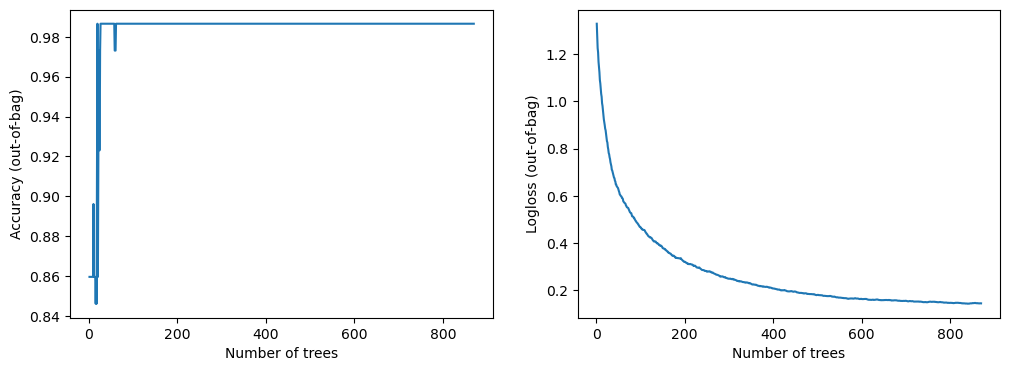


Train: 0.0958 Validation: 0.2744
##### Fold 7
Use /tmp/tmpfalnnlzp as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:25:14.2770 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:14.2771 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:14.2771 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.425143. Found 555 examples.
Training model...
Model trained in 0:00:00.569456
Compiling model...


[INFO 23-07-20 09:25:16.2785 UTC kernel.cc:1242] Loading model from path /tmp/tmpfalnnlzp/model/ with prefix ac634cefa0464961
[INFO 23-07-20 09:25:16.2841 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 291ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2420


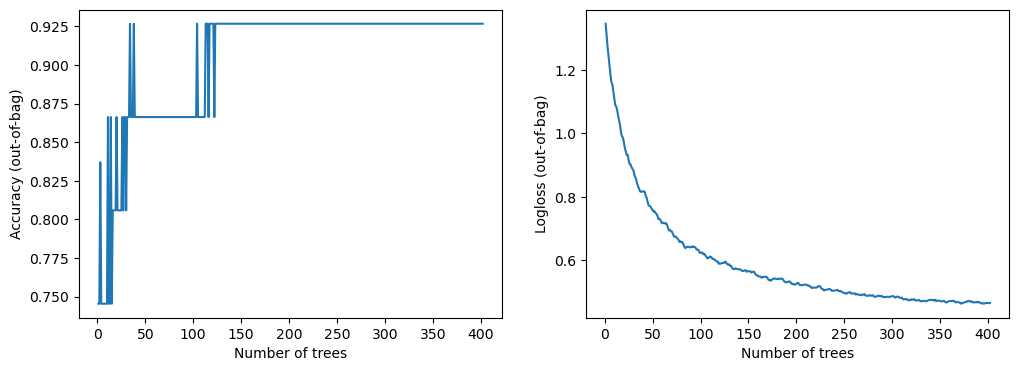


Train: 0.1518 Validation: 0.2420
##### Fold 8
Use /tmp/tmpldr9onyw as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:25:19.4265 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:19.4266 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:19.4266 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.386880. Found 556 examples.
Training model...
Model trained in 0:00:00.570239
Compiling model...


[INFO 23-07-20 09:25:21.3894 UTC kernel.cc:1242] Loading model from path /tmp/tmpldr9onyw/model/ with prefix 33dccde517ed4f53
[INFO 23-07-20 09:25:21.3950 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:25:21.3951 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2632


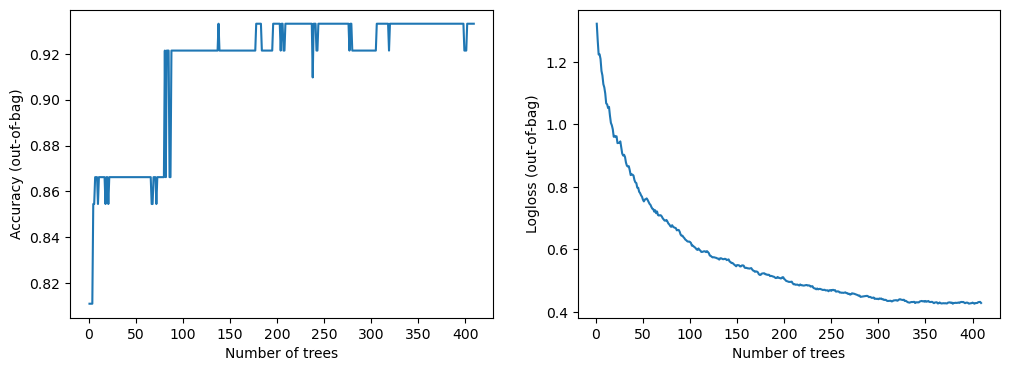


Train: 0.1428 Validation: 0.2632
##### Fold 9
Use /tmp/tmpxqh2ghn7 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:25:24.6581 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:24.6582 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:24.6582 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.318640. Found 556 examples.
Training model...
Model trained in 0:00:00.773645
Compiling model...


[INFO 23-07-20 09:25:26.7576 UTC kernel.cc:1242] Loading model from path /tmp/tmpxqh2ghn7/model/ with prefix 025656048ef041a0
[INFO 23-07-20 09:25:26.7654 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 293ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3122


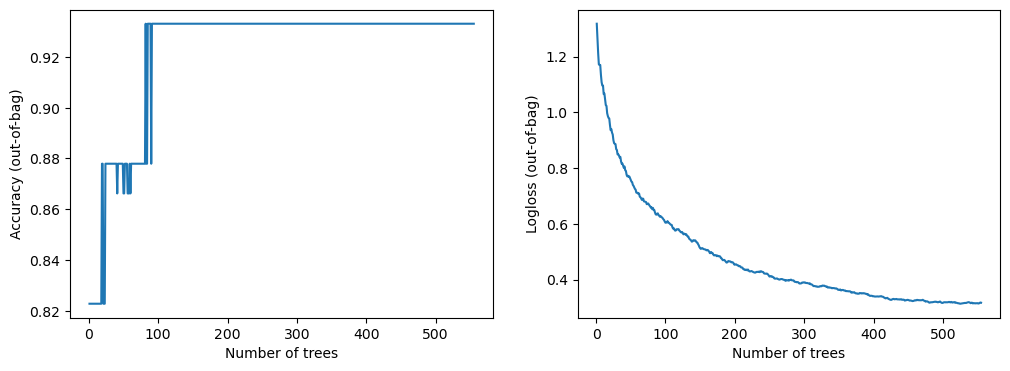


Train: 0.1171 Validation: 0.3122
##### Fold 10
Use /tmp/tmpoal77rfp as temporary training directory
Reading training dataset...


[WARNING 23-07-20 09:25:30.9218 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:30.9219 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 09:25:30.9219 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.416137. Found 556 examples.
Training model...
Model trained in 0:00:00.650083
Compiling model...


[INFO 23-07-20 09:25:32.9935 UTC kernel.cc:1242] Loading model from path /tmp/tmpoal77rfp/model/ with prefix 480fefd171ba4fd6
[INFO 23-07-20 09:25:32.9999 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 09:25:33.0000 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 287ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1399


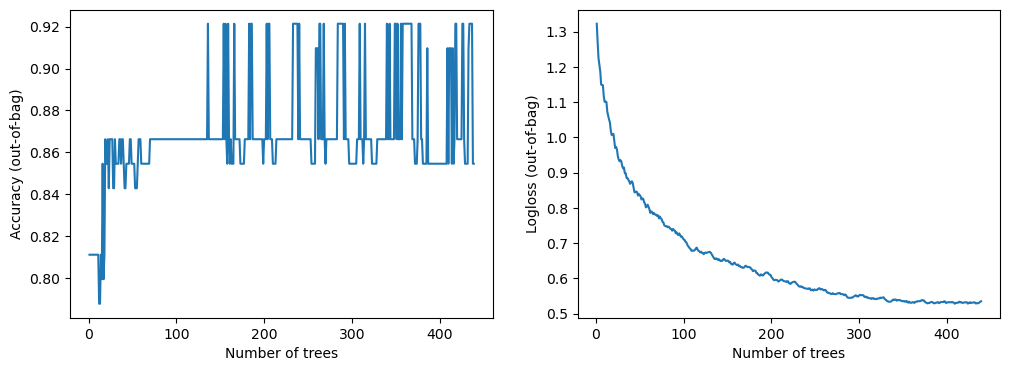


Train: 0.1509 Validation: 0.1399

Train mean: 0.1271 std: 0.0197

Validation mean: 0.2420 std: 0.0670


In [13]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

# TabPFN

In [14]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

In [15]:
def train_model_tabpfn_one(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    submition_df = pd.DataFrame(data=np.zeros((len(submition.index),1)),index=submition.index)
    train_df_out = pd.DataFrame(data=np.zeros((len(train.index),1)),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_sub = model.predict_proba(submition[features])[:,1]

    # Predict value for validation/Submition data
    submition_df[0] = p_sub.flatten() 
    train_df_out[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
            
    # metrics['accuracy'] = accuracy_score(train_df[label].values, p_train)
    train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    metrics['balanced_logloss'] = train_metric
    print(f"\nTrain: {train_metric:.4f}")
    
            
    return train_df_out,submition_df,model,metrics

In [16]:

def train_model_tabpfn_cv(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    # out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition_out = pd.DataFrame(data=np.zeros((len(submition.index),n_splits)),index=submition.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(submition[features])[:,1]
            
            # out_of_fold.loc[valid_ids, 0] = p_val
            submition_out[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return submition,models,metrics

In [17]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_tabpfn_1, submition_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
    train=train_out,submition=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [18]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
submition_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,submition=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Submission

In [19]:
submition_rf_3, model_rf_3,metrics_rf_3

(                 0         1         2         3         4     5     6    7  \
 Id                                                                            
 00eed32682bb  0.35  0.353333  0.386666  0.346666  0.356666  0.39  0.36  0.4   
 010ebe33f668  0.35  0.353333  0.386666  0.346666  0.356666  0.39  0.36  0.4   
 02fa521e1838  0.35  0.353333  0.386666  0.346666  0.356666  0.39  0.36  0.4   
 040e15f562a2  0.35  0.353333  0.386666  0.346666  0.356666  0.39  0.36  0.4   
 046e85c7cc7f  0.35  0.353333  0.386666  0.346666  0.356666  0.39  0.36  0.4   
 
                  8     9  
 Id                        
 00eed32682bb  0.36  0.39  
 010ebe33f668  0.36  0.39  
 02fa521e1838  0.36  0.39  
 040e15f562a2  0.36  0.39  
 046e85c7cc7f  0.36  0.39  ,
 {'fold_1': <tensorflow_decision_forests.keras.RandomForestModel at 0x7c23747c9360>,
  'fold_2': <tensorflow_decision_forests.keras.RandomForestModel at 0x7c2374632890>,
  'fold_3': <tensorflow_decision_forests.keras.RandomForestModel at 0x7

In [20]:
submition_rf_3

,0,1,2,3,4,5,6,7,8,9
Id,,,,,,,,,,
00eed32682bb,0.35,0.353333,0.386666,0.346666,0.356666,0.39,0.36,0.4,0.36,0.39
010ebe33f668,0.35,0.353333,0.386666,0.346666,0.356666,0.39,0.36,0.4,0.36,0.39
02fa521e1838,0.35,0.353333,0.386666,0.346666,0.356666,0.39,0.36,0.4,0.36,0.39
040e15f562a2,0.35,0.353333,0.386666,0.346666,0.356666,0.39,0.36,0.4,0.36,0.39
046e85c7cc7f,0.35,0.353333,0.386666,0.346666,0.356666,0.39,0.36,0.4,0.36,0.39


In [21]:
metrics_rf_3

{'train': {'fold_1': nan,
  'fold_2': nan,
  'fold_3': nan,
  'fold_4': nan,
  'fold_5': nan,
  'fold_6': nan,
  'fold_7': nan,
  'fold_8': nan,
  'fold_9': nan,
  'fold_10': nan},
 'val': {'fold_1': 0.24696135520935059,
  'fold_2': 0.2757072448730469,
  'fold_3': nan,
  'fold_4': nan,
  'fold_5': nan,
  'fold_6': nan,
  'fold_7': nan,
  'fold_8': nan,
  'fold_9': 0.3448503017425537,
  'fold_10': 0.26867955923080444}}

In [22]:
metrics_gbt_2

{'train': {'fold_1': 0.11266271770000458,
  'fold_2': 0.14179548621177673,
  'fold_3': 0.11891129612922668,
  'fold_4': 0.13285349309444427,
  'fold_5': 0.10589471459388733,
  'fold_6': 0.09579741954803467,
  'fold_7': 0.15179726481437683,
  'fold_8': 0.14282067120075226,
  'fold_9': 0.11710572242736816,
  'fold_10': 0.15086781978607178},
 'val': {'fold_1': 0.1639588177204132,
  'fold_2': 0.15759237110614777,
  'fold_3': 0.33841216564178467,
  'fold_4': 0.2671264111995697,
  'fold_5': 0.2613404393196106,
  'fold_6': 0.2743731141090393,
  'fold_7': 0.2420138418674469,
  'fold_8': 0.2631709575653076,
  'fold_9': 0.31219035387039185,
  'fold_10': 0.1399126946926117}}

In [23]:
metrics_tabpfn_1

{'balanced_logloss': 0.05152794842815339}

In [24]:
metrics_tabpfn_2

{'train': {'fold_1': 0.0558617324818663,
  'fold_2': 0.055303151158023596,
  'fold_3': 0.05375296697090612,
  'fold_4': 0.044770280142164075,
  'fold_5': 0.05179097748184901,
  'fold_6': 0.051143382468489665},
 'val': {'fold_1': 0.17063073176848337,
  'fold_2': 0.2929021067073241,
  'fold_3': 0.29681072611117915,
  'fold_4': 0.19851962478779311,
  'fold_5': 0.46818426215745335,
  'fold_6': 0.11781347642142413}}

In [25]:
# Aggragate Subs

RF_m = pd.Series(metrics_rf_3['val']).mean()
GBT_m = pd.Series(metrics_gbt_2['val']).mean()
TabPFN_m = pd.Series(metrics_tabpfn_2['val']).mean()

print('RF: metric ', RF_m)
print('GBT: metric ', GBT_m)
print('TabPFN: metric ', TabPFN_m)

Total_m = GBT_m + RF_m + TabPFN_m

RF_w = 2/10
GBT_w = 4.5/10
TabPFN_w = 3.5/10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

RF: metric  0.2840496152639389
GBT: metric  0.24200911670923234
TabPFN: metric  0.2574768213256095
RF weight:  0.2
GBT weight:  0.45
TabPFN weight:  0.35


In [26]:
submition_total = pd.concat([submition_rf_3.mean(axis=1).to_frame(),
                             submition_gbt_2.mean(axis=1).to_frame(),
                             submition_tabpfn_2.mean(axis=1).to_frame()
                            ],
                            axis=1)
submition_total.columns = ['RF','GBT','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

# submition_total

submition_total = submition_total[['Ensemble']].copy()

submition_total.columns = ['class_1']

submition_total['class_0'] = 1 - submition_total['class_1']

/tmp/ipykernel_20/3336756922.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  submition_tabpfn_2.mean(axis=1).to_frame()


In [27]:
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [28]:
submition_total

,class_1,class_0
Id,,
00eed32682bb,0.188668,0.811332
010ebe33f668,0.188668,0.811332
02fa521e1838,0.188668,0.811332
040e15f562a2,0.188668,0.811332
046e85c7cc7f,0.188668,0.811332
